# Generating datasets to train the berry detection and segmentation models

In [1]:
import os
os.chdir('C:/Users/davietbe/Documents/develop')

In [2]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

from deepberry.src.openalea.deepberry.training.training_dataset import labelme_json_postprocessing, generate_detection_vignette, generate_segmentation_vignette
from deepberry.src.openalea.deepberry.utils import ellipse_interpolation

# 1. Loading of annotated data

## Loads an image an its corresponding labels Each label is a polygon. Only berries with >50% contours visible were annotated. Polygon points must only be placed were these contours are visible.

In [3]:
image = cv2.cvtColor(cv2.imread('deepberry/examples/data/training/image.png'), cv2.COLOR_BGR2RGB)

labels_path = 'deepberry/examples/data/training/labels.json'
with open(labels_path) as f:
    raw_labels = json.load(f)

## Displays it

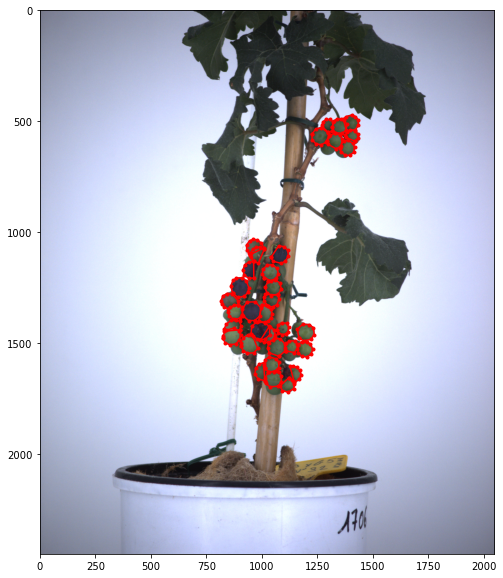

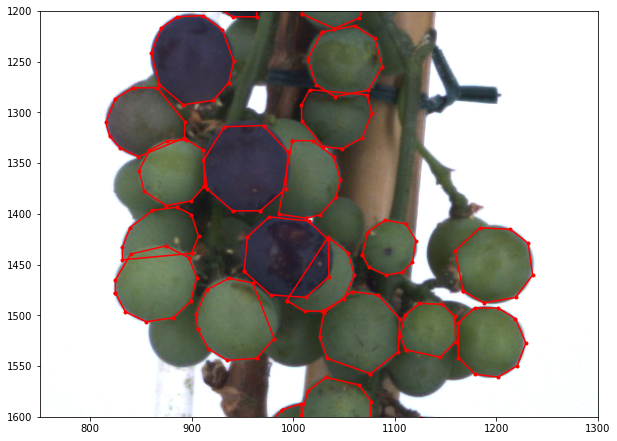

In [4]:
for zoom in [False, True]:
    plt.figure()
    plt.imshow(image)
    for shape in raw_labels['shapes']:
        points = np.array(shape['points'])
        points = np.concatenate((points, [points[0]]))
        plt.plot(points[:, 0], points[:, 1], 'r.-')
        if zoom: 
            plt.xlim((750, 1300))
            plt.ylim((1600, 1200))

# 2. Conversion of the labels to box & ellipse parameters

## Converts polygon labels from the .json Labelme format to ellipse and box parameters, using ellipse fitting

In [5]:
labels = labelme_json_postprocessing(labels_path)

## Displays a few rows from the reformatted labels

In [6]:
print(labels.iloc[:5])

         ell_x       ell_y      ell_w      ell_h       ell_a        box_x  \
0  1298.132202  518.919495  54.202049  59.932858  167.553940  1298.132202   
1  1348.776367  521.626099  68.387878  69.524399  175.206879  1348.776367   
2  1329.076172  588.526428  69.298958  70.581642   12.114693  1329.076172   
3  1262.060547  566.753113  75.269562  79.666199   45.031830  1262.060547   
4  1383.757935  619.144653  65.862106  71.608299  146.561005  1383.757935   

        box_y      box_w      box_h  
0  518.919495  54.474683  59.670038  
1  521.626099  68.386157  69.501990  
2  588.526428  69.344433  70.509425  
3  566.753113  77.490734  77.486244  
4  619.144653  67.649554  69.903179  


## Displays the resulting boxes (blue) and ellipses (orange) on the image

(1736.965087890625, 458.7367248535156)

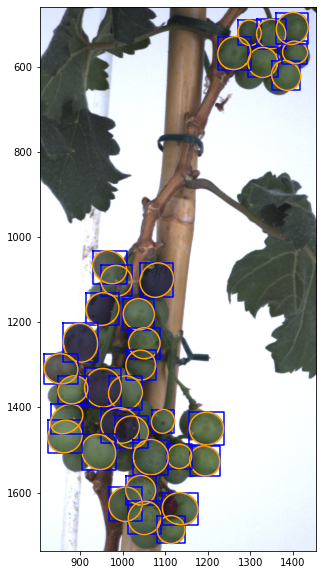

In [7]:
plt.imshow(image)
for _, (xe, ye, we, he, ae, xb, yb, wb, hb) in labels.iterrows():
    # box
    plt.plot([xb - wb/2, xb - wb/2, xb + wb/2, xb + wb/2, xb - wb/2], 
             [yb - hb/2, yb + hb/2, yb + hb/2, yb - hb/2, yb - hb/2], 'b-')
    # ellipse
    lsp_x, lsp_y = ellipse_interpolation(x=xe, y=ye, w=we, h=he, a=ae, n_points=50)
    plt.plot(lsp_x, lsp_y, '-', color='orange')
# zoom
plt.xlim((min(labels['box_x']) - 50, max(labels['box_x']) + 50))
plt.ylim((max(labels['box_y']) + 50, min(labels['box_y']) - 50))

# 3. Generates an instance to train the Yolov4 detection model

## Crops and saves a 416x416 vignette (.png) from the original image, and its corresponding labels (.txt)

In [8]:
_ = generate_detection_vignette(image=image, labels=labels, output_path='det_instance1', 
                                target_berry_center=None)

## Loads and displays it

label file in the yolov4 format : 



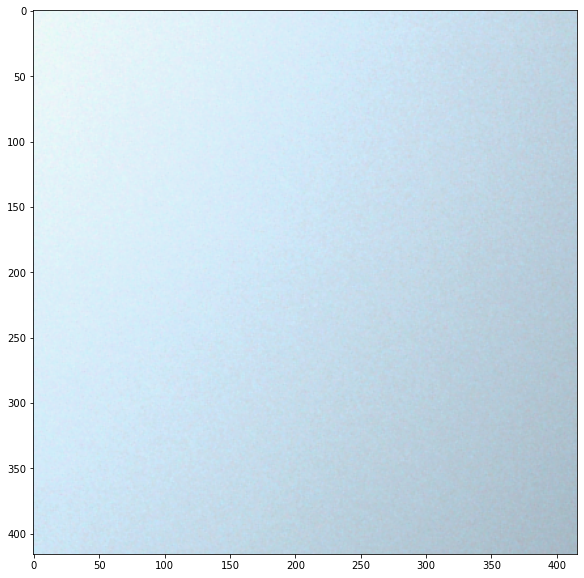

In [9]:
vignette = cv2.cvtColor(cv2.imread('det_instance1.png'), cv2.COLOR_BGR2RGB)
with open('det_instance1.txt') as f:
    label = f.readlines()
    
print('label file in the yolov4 format : \n')
for line in label:
    print(line)
plt.imshow(vignette)

## In the previous code section, the center position used to crop the vignette was chosen randomly: it may often result in a vignette with no berries. Instead, the center of a berry can be used as a rough target position for the cropping.

In [17]:
_ = generate_detection_vignette(image=image, labels=labels, output_path='det_instance2', 
                                target_berry_center=tuple(labels.iloc[0][['ell_x', 'ell_y']]), 
                                random_center_proba=0)

## Loads and displays the new instance

label file in the yolov4 format : 

0 0.6921141697810247 0.5044898986816406 0.14343759168697218 0.13094875664741706

0 0.6986204294057993 0.3827491173377404 0.16707209074850043 0.16438979933026915

0 0.8594385293813852 0.43010535606971156 0.16949381034142272 0.16669334942918057

0 0.8070988288292518 0.5912006084735577 0.18626501017578925 0.18627580237030428

0 0.8031041071965144 0.24827428964468146 0.12813648848330098 0.1408199113596911

0 0.667636357820951 0.26389195368840146 0.18036859696011612 0.17993268525264156



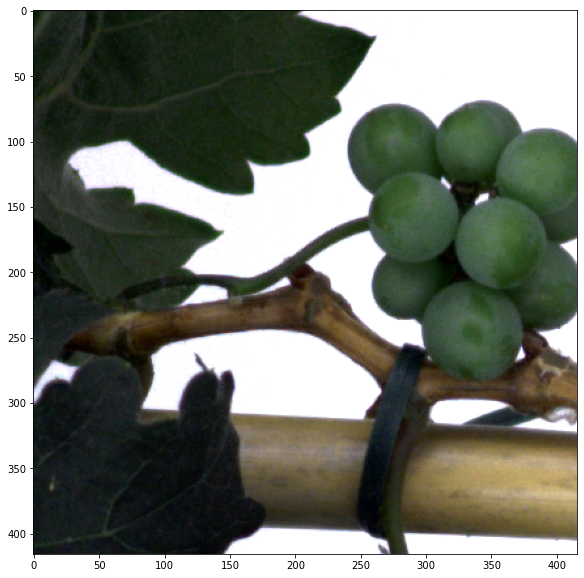

In [19]:
vignette = cv2.cvtColor(cv2.imread('det_instance2.png'), cv2.COLOR_BGR2RGB)
with open('det_instance2.txt') as f:
    label = f.readlines()
    
print('label file in the yolov4 format : \n')
for line in label:
    print(line)
plt.imshow(vignette)

# 4. Generates an instance to train the U-Net segmentation model

## Crops and saves a 128x128 vignette (.png) from the original image, and its corresponding 128x128 vignette label (.png)

In [28]:
_ = generate_segmentation_vignette(image=image, label=labels.iloc[0], output_path='seg_instance')

## Displays it

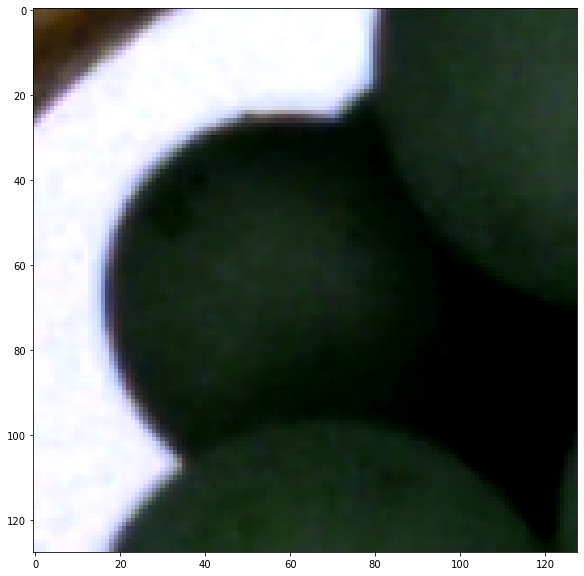

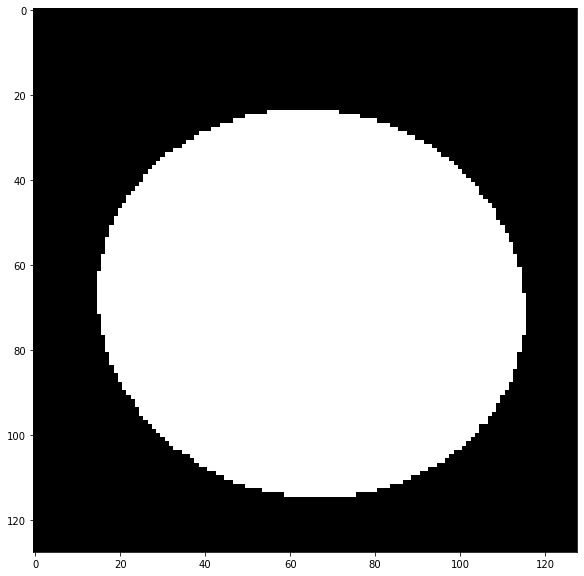

In [21]:
x = cv2.cvtColor(cv2.imread('seg_instancex.png'), cv2.COLOR_BGR2RGB)
y = cv2.cvtColor(cv2.imread('seg_instancey.png'), cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(x)
plt.figure()
plt.imshow(y)